In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seastar
# from cycler import cycler


In [60]:
# Increase default Font Size
plt.rcParams.update({'font.size': 18})

In [61]:
noise_RSV_sqt = 0.07
noise_RSV_broad = 0.2

Kp_sqt = 0.03
Kp_broad = 0.04

In [62]:
wspd_target = [5, 9, 15]
# azi_target = [0, 90]
pol_target = [1]
inci_broad_target = [20, 28.4, 33.4]
inci_sqt_target = [31.5, 36.5, 40.0]
across_distance = [0, 90, 150]

### CHANGE of SQUINT GROUND along swath ####
# sqt_ground = [45.0, 45.0, 45.0] # fix sqt of 45°
sqt_ground = [52.2, 45.0, 37.8] # effectively 50, 45, 40 # SEASTAR version
# sqt_ground = [55, 45.0, 35] # more extrem, keep same behavior
# sqt_ground = [29, 26, 22.5] # effectively 30, 25, 20 for sqt29 config

In [63]:
wspd_lim = [1, 20]

# Sensitivity to Wind Direction

In [64]:
azi_step =  5

# pol   =  np.array([1])
wspd  =  np.array( wspd_target )
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[wspd_mat, theta_broad_mat, azi_mat] =  np.meshgrid(wspd, theta_broad, azi, indexing='ij')
[wspd_mat, theta_sqt_mat, azi_mat] =  np.meshgrid(wspd, theta_sqt, azi, indexing='ij')

# RSV
dop_broad_VV = seastar.gmfs.doppler.mouche12(
    wspd_mat,
    azi_mat,
    theta_broad_mat,
    'VV',
)

dop_sqt_VV = seastar.gmfs.doppler.mouche12(
    wspd_mat,
    azi_mat,
    theta_sqt_mat,
    'VV',
)

[trash, WASV_broad_VV] = seastar.gmfs.doppler.convertDoppler2Velocity(
    5.5, 
    dop_broad_VV, 
    theta_broad_mat
)
[trash, WASV_sqt_VV] = seastar.gmfs.doppler.convertDoppler2Velocity(
    5.5, 
    dop_sqt_VV, 
    theta_sqt_mat
)

# NRCS
s0_lin_broad = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    seastar.utils.tools.reduce_0_360_to_0_180(azi_mat),
    theta_broad_mat,
    np.ones(np.shape(wspd_mat)),
)

s0_lin_sqt = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    seastar.utils.tools.reduce_0_360_to_0_180(azi_mat),
    theta_sqt_mat,
    np.ones(np.shape(wspd_mat)),
)



In [65]:
ds = xr.Dataset(
    data_vars=dict(
        WASV=(['wspd','cell','azi','antenna'], np.stack([WASV_broad_VV, WASV_sqt_VV], axis=-1)),
        sigma0_lin=(['wspd','cell','azi','antenna'], np.stack([s0_lin_broad, s0_lin_sqt], axis=-1))
        
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        wspd=wspd,
        azi=azi,
        sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds.WASV.attrs['long_name'] = 'WASV'
ds.WASV.attrs['units'] = 'm/s'
ds.sigma0_lin.attrs['units'] = 'lin'
ds.sigma0_lin.attrs['long_name'] = 'sigma0'
ds.wspd.attrs['long_name'] = 'Wind Speed'
ds.wspd.attrs['units'] = 'm/s'
ds.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds.inci_broad.attrs['units'] = '°'
ds.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds.inci_sqt.attrs['units'] = '°'
ds.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds.azi.attrs['units'] = '°'

In [66]:
# WASV
ds['dWASV_dazi_2'] = ds.WASV.differentiate('azi')**2

# NRCS
ds['ds0lin_dazi_2'] = ds.sigma0_lin.differentiate('azi')**2
ds['mean_s0lin'] = ds.sigma0_lin.mean(dim='azi')

In [67]:
ds['shift_fore'] = np.round((90-ds.sqt_ground)/azi_step).astype(np.intc)
ds['shift_broad'] = (('cell'), np.round((90*np.ones(ds.sqt_ground.shape))/azi_step).astype(np.intc))
ds['shift_aft'] = np.round((90+ds.sqt_ground)/azi_step).astype(np.intc)

ds['eff_sqt_ground'] = 90-ds.shift_fore.astype(np.double) * azi_step
ds = ds.set_coords(['shift_fore', 'shift_broad', 'shift_aft', 'eff_sqt_ground'])

In [68]:
ds

<xarray.Dataset>
Dimensions:          (wspd: 3, cell: 3, azi: 72, antenna: 2)
Coordinates:
  * cell             (cell) <U4 'near' 'mid' 'far'
    inci_broad       (cell) float64 20.0 28.4 33.4
    inci_sqt         (cell) float64 31.5 36.5 40.0
  * antenna          (antenna) <U5 'broad' 'sqt'
  * wspd             (wspd) int32 5 9 15
  * azi              (azi) int32 0 5 10 15 20 25 30 ... 330 335 340 345 350 355
    sqt_ground       (cell) float64 52.2 45.0 37.8
    across_distance  (cell) int32 0 90 150
    shift_fore       (cell) int32 8 9 10
    shift_broad      (cell) int32 18 18 18
    shift_aft        (cell) int32 28 27 26
    eff_sqt_ground   (cell) float64 50.0 45.0 40.0
Data variables:
    WASV             (wspd, cell, azi, antenna) float64 -1.817 -1.083 ... -1.226
    sigma0_lin       (wspd, cell, azi, antenna) float64 0.4251 ... 0.1231
    dWASV_dazi_2     (wspd, cell, azi, antenna) float64 3.117e-05 ... 5.114e-06
    ds0lin_dazi_2    (wspd, cell, azi, antenna) float64 1.829e-08 ... 1.039e-07
    mean_s0lin       (wspd, cell, antenna) float64 0.3922 0.022 ... 0.08069

In [69]:
norm_dWASVdazi_2_fore = [None] * ds.cell.size
norm_dWASVdazi_2_broad= [None] * ds.cell.size
norm_dWASVdazi_2_aft  = [None] * ds.cell.size

norm_ds0lindazi_2_fore = [None] * ds.cell.size
norm_ds0lindazi_2_broad= [None] * ds.cell.size
norm_ds0lindazi_2_aft  = [None] * ds.cell.size

for cc, cell in enumerate(ds.cell):
    # WASV
    norm_dWASVdazi_2_fore[cc] = ds.dWASV_dazi_2.roll(azi=cell.shift_fore.data).sel(antenna='sqt', cell=cell.data) / noise_RSV_sqt**2
    norm_dWASVdazi_2_broad[cc] = ds.dWASV_dazi_2.roll(azi=cell.shift_broad.data).sel(antenna='broad', cell=cell.data)  / noise_RSV_broad**2
    norm_dWASVdazi_2_aft[cc] = ds.dWASV_dazi_2.roll(azi=cell.shift_aft.data).sel(antenna='sqt', cell=cell.data)  / noise_RSV_sqt**2

    # NRCS
    norm_ds0lindazi_2_fore[cc] = ds.ds0lin_dazi_2.roll(azi=cell.shift_fore.data).sel(antenna='sqt', cell=cell.data) / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt', cell=cell.data) )**2
    norm_ds0lindazi_2_broad[cc] = ds.ds0lin_dazi_2.roll(azi=cell.shift_broad.data).sel(antenna='broad', cell=cell.data)  / (Kp_broad * ds.mean_s0lin.sel(antenna='broad', cell=cell.data) )**2
    norm_ds0lindazi_2_aft[cc] = ds.ds0lin_dazi_2.roll(azi=cell.shift_aft.data).sel(antenna='sqt', cell=cell.data)  / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt', cell=cell.data) )**2

   

In [70]:
 
ds['norm_dWASVdazi_2_fore'] = xr.concat(norm_dWASVdazi_2_fore, dim='cell')
ds['norm_dWASVdazi_2_broad']= xr.concat(norm_dWASVdazi_2_broad, dim='cell')
ds['norm_dWASVdazi_2_aft']  = xr.concat(norm_dWASVdazi_2_aft, dim='cell')

ds['norm_ds0lindazi_2_fore'] = xr.concat(norm_ds0lindazi_2_fore, dim='cell')
ds['norm_ds0lindazi_2_broad'] =xr.concat(norm_ds0lindazi_2_broad, dim='cell')
ds['norm_ds0lindazi_2_aft'] = xr.concat(norm_ds0lindazi_2_aft, dim='cell')
    

ds['norm_dWASVdazi_2_tot_sqt'] = ds['norm_dWASVdazi_2_fore'] + ds['norm_dWASVdazi_2_aft']
ds['norm_dWASVdazi_2_tot'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_dWASVdazi_2_broad']


ds['norm_ds0lindazi_2_tot_sqt'] = ds['norm_ds0lindazi_2_fore'] + ds['norm_ds0lindazi_2_aft']
ds['norm_ds0lindazi_2_tot'] = ds['norm_ds0lindazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_broad']

# Tot
ds['norm_dHdazi_2_tot_sqt'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_tot_sqt']
ds['norm_dHdazi_2_tot_sqt_s0_broad'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_tot']
ds['norm_dHdazi_2_tot'] = ds['norm_dWASVdazi_2_tot'] + ds['norm_ds0lindazi_2_tot']

# Ratio
ds['norm_dRdazi_2_tot_sqt'] = ds['norm_dWASVdazi_2_tot_sqt'] / ds['norm_ds0lindazi_2_tot_sqt']
ds['norm_dRdazi_2_tot_sqt_s0_broad'] = ds['norm_dWASVdazi_2_tot_sqt'] / ds['norm_ds0lindazi_2_tot']
ds['norm_dRdazi_2_tot'] = ds['norm_dWASVdazi_2_tot'] / ds['norm_ds0lindazi_2_tot']

In [71]:
# shift_fore  = int(np.round(45/azi_step))
# shift_broad = int(np.round(90/azi_step))
# shift_aft   = int(np.round(135/azi_step))

# # WASV
# ds['norm_dWASVdazi_2_fore'] = ds.dWASV_dazi_2.roll(azi=shift_fore).sel(antenna='sqt') / noise_RSV_sqt**2
# ds['norm_dWASVdazi_2_broad'] = ds.dWASV_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / noise_RSV_broad**2
# ds['norm_dWASVdazi_2_aft'] = ds.dWASV_dazi_2.roll(azi=shift_aft).sel(antenna='sqt')  / noise_RSV_sqt**2
# ds['norm_dWASVdazi_2_tot_sqt'] = ds['norm_dWASVdazi_2_fore'] + ds['norm_dWASVdazi_2_aft']
# ds['norm_dWASVdazi_2_tot'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_dWASVdazi_2_broad']

# # NRCS
# ds['norm_ds0lindazi_2_fore'] = ds.ds0lin_dazi_2.roll(azi=shift_fore).sel(antenna='sqt') / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
# ds['norm_ds0lindazi_2_broad'] = ds.ds0lin_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.mean_s0lin.sel(antenna='broad') )**2
# ds['norm_ds0lindazi_2_aft'] = ds.ds0lin_dazi_2.roll(azi=shift_aft).sel(antenna='sqt')  / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
# ds['norm_ds0lindazi_2_tot_sqt'] = ds['norm_ds0lindazi_2_fore'] + ds['norm_ds0lindazi_2_aft']
# ds['norm_ds0lindazi_2_tot'] = ds['norm_ds0lindazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_broad']

# # Tot
# ds['norm_dHdazi_2_tot_sqt'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_tot_sqt']
# ds['norm_dHdazi_2_tot_sqt_s0_broad'] = ds['norm_dWASVdazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_tot']
# ds['norm_dHdazi_2_tot'] = ds['norm_dWASVdazi_2_tot'] + ds['norm_ds0lindazi_2_tot']

In [72]:
# Test for the normalisation with Sigma0 at the given azimuth instead of the mean sigma0 over all azimuth 
# => Does not affect dramaticaly the results, same behaviour even if changes at the peak of sensitivity (not strong at Near + low WSpd)
# ds['norm_ds0lindazi_2b_broad'] = ds.ds0lin_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.sigma0_lin.sel(antenna='broad') )**2

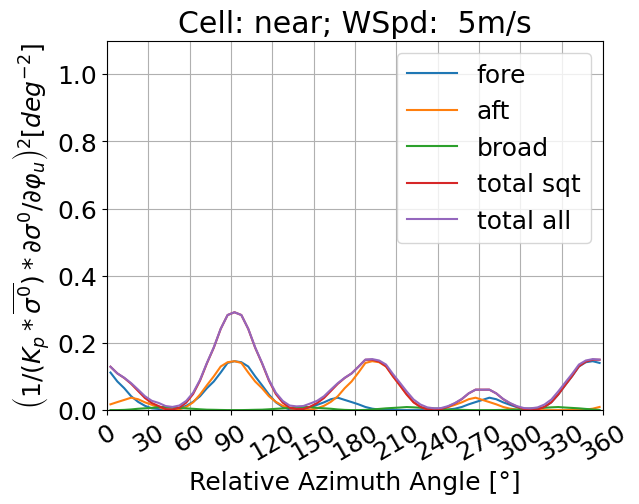

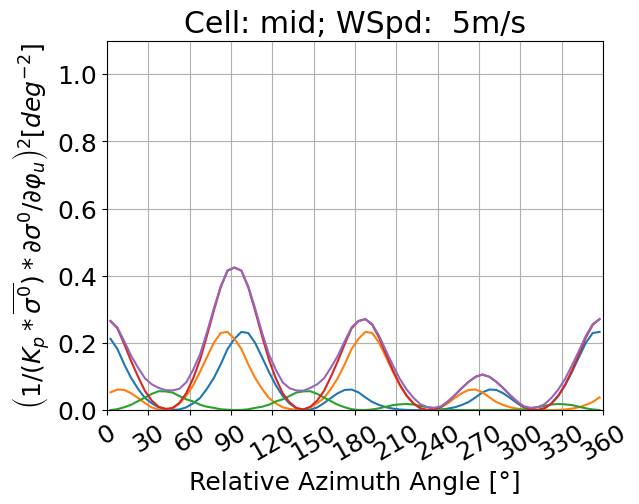

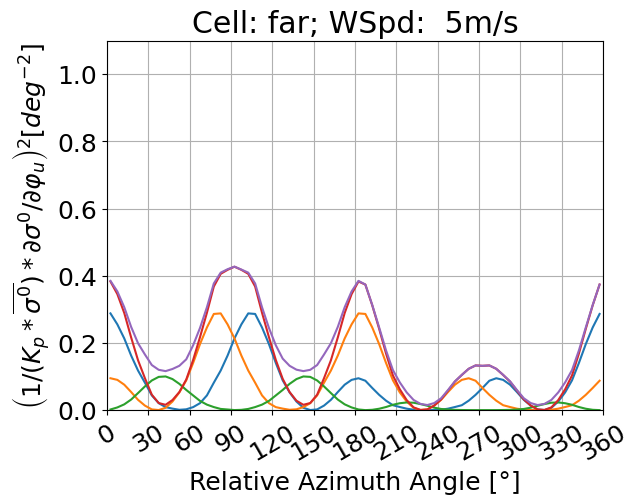

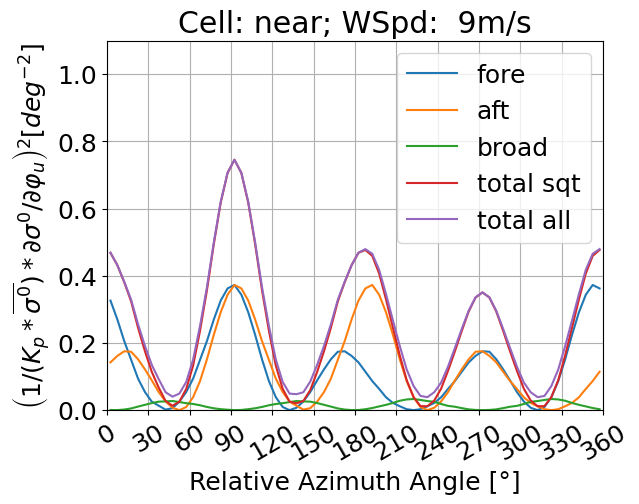

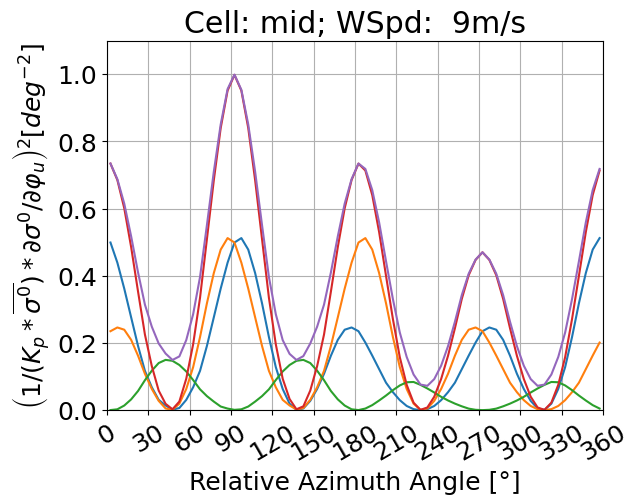

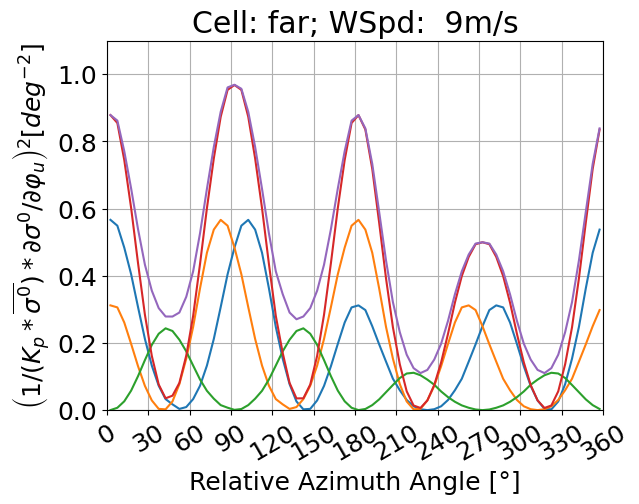

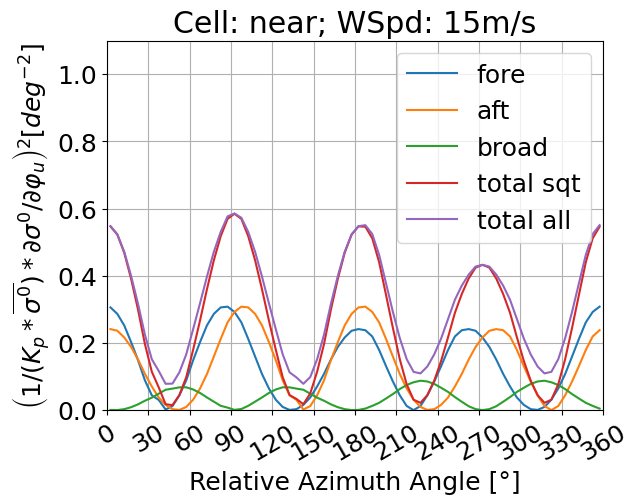

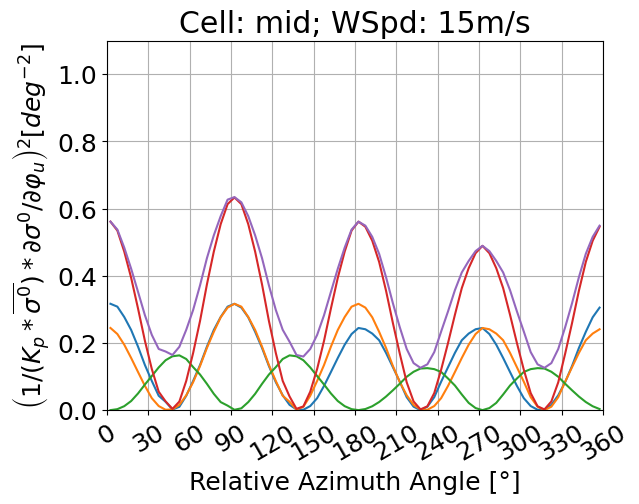

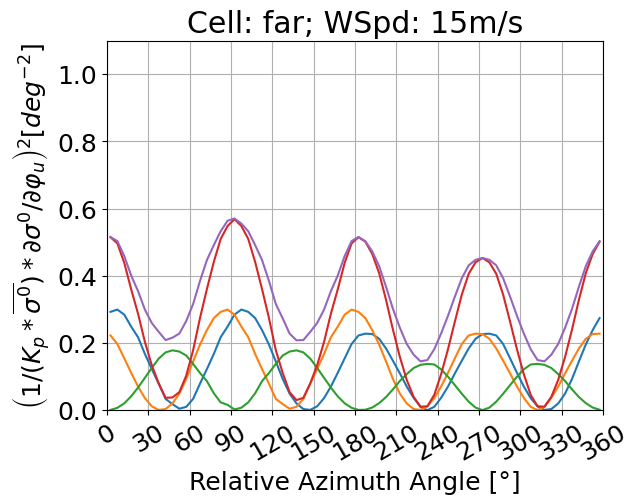

In [73]:
fig_ylim = 1.1

for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_ds0lindazi_2_fore\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_ds0lindazi_2_aft\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_ds0lindazi_2_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='broad',
                )
        ds.norm_ds0lindazi_2_tot_sqt\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_ds0lindazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all',
                )
        #plt.xticks(np.arange(0,361,30))
        plt.xticks(np.arange(-azi_step/2,361,30), np.arange(0,361,30), rotation=30) # shift by azi_step/2 linked to differentiation
        plt.xlim([-azi_step/2,360-azi_step/2]) # shift by azi_step/2 linked to differentiation
        plt.ylim([0,fig_ylim]) ################### TO CHANGE for WPSD > 5 m/s ###########
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        if cell=='near':
            plt.legend()
        plt.ylabel(r'$\left(1/(K_p * \overline{\sigma^0}) * \partial{\sigma^0}/\partial{\varphi_u}\right)^2 [deg^{-2}]$')
        plt.savefig('../../../SciRec_paper_figures_appendix/' +
                    f'nscat_seastar_wind_sensi_{cell}_wspd{wspd:02.0f}_ylim{fig_ylim:.2f}.png', bbox_inches='tight')

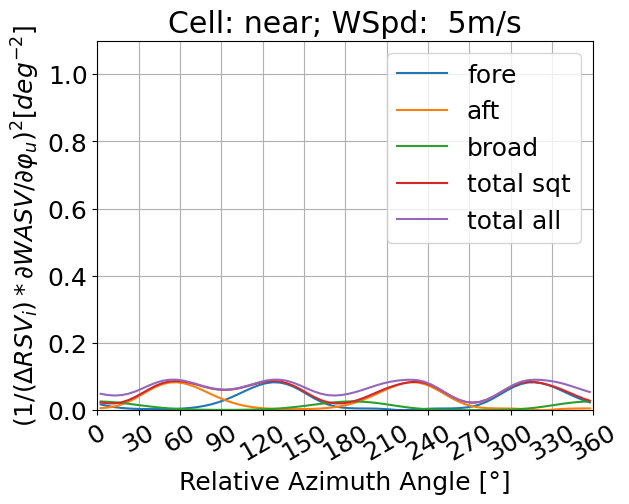

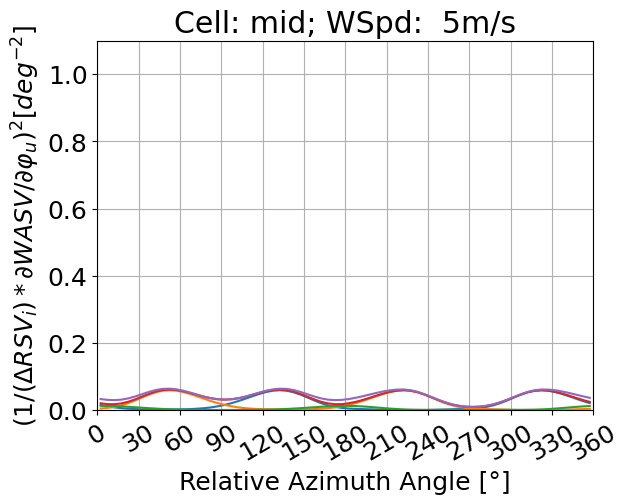

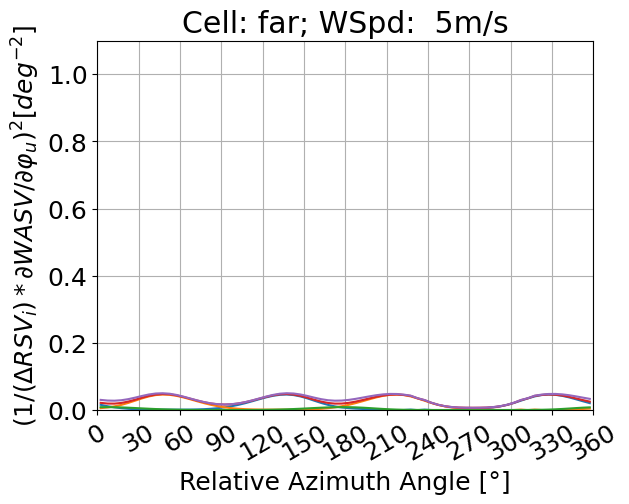

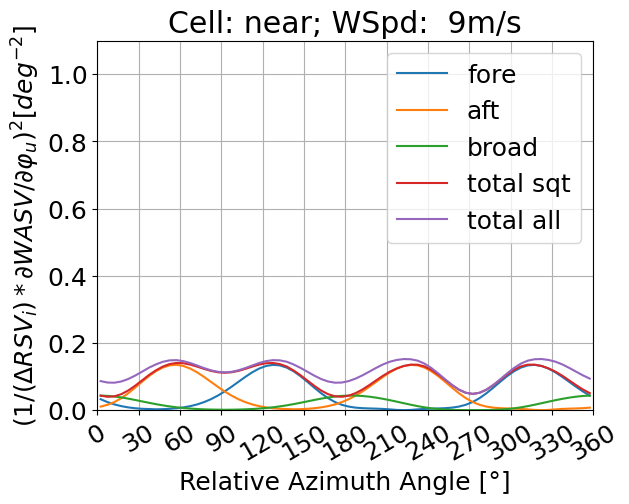

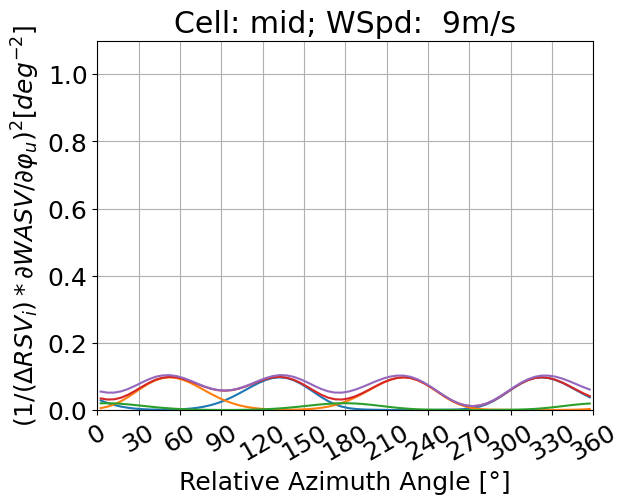

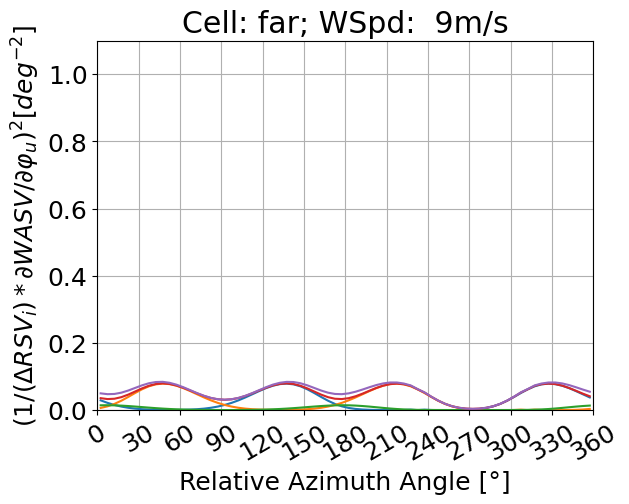

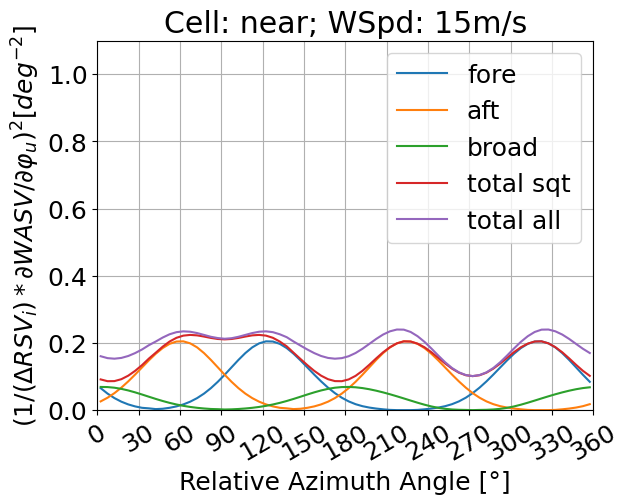

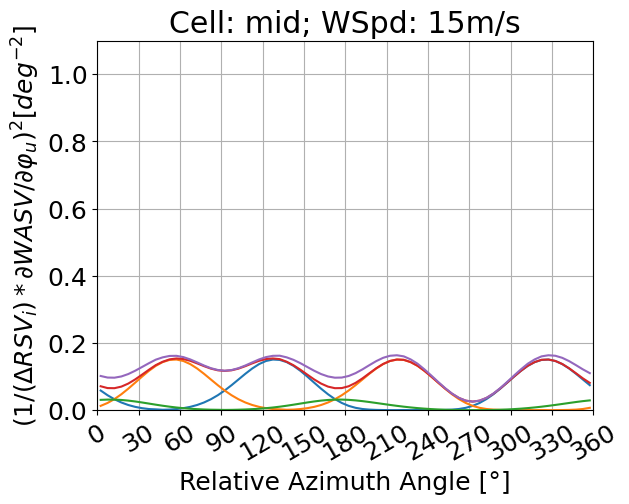

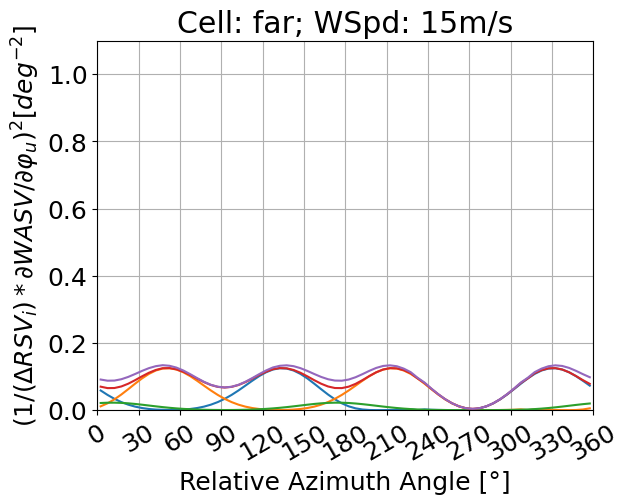

In [75]:
fig_ylim = 1.1

for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_dWASVdazi_2_fore\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_dWASVdazi_2_aft\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_dWASVdazi_2_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='broad',
                )
        ds.norm_dWASVdazi_2_tot_sqt\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_dWASVdazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all',
                )
        #plt.xticks(np.arange(0,361,30))
        #plt.grid()
        #plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        #plt.legend()
        #plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{WASV}/\partial{\varphi_u}\right)^2$')
        plt.xticks(np.arange(-azi_step/2,361,30), np.arange(0,361,30),rotation=30) # shift by azi_step/2 linked to differentiation
        plt.xlim([-azi_step/2,360-azi_step/2]) # shift by azi_step/2 linked to differentiation
        plt.ylim([0,fig_ylim]) ################### TO CHANGE for WPSD > 5 m/s ###########
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        if cell=='near':
            plt.legend()
        plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{WASV}/\partial{\varphi_u}\right)^2 [deg^{-2}]$')
        plt.savefig('../../../SciRec_paper_figures_appendix/' + 
                    f'mouche_seastar_wind_sensi_{cell}_wspd{wspd:02.0f}_ylim{fig_ylim:.2f}.png', bbox_inches='tight')

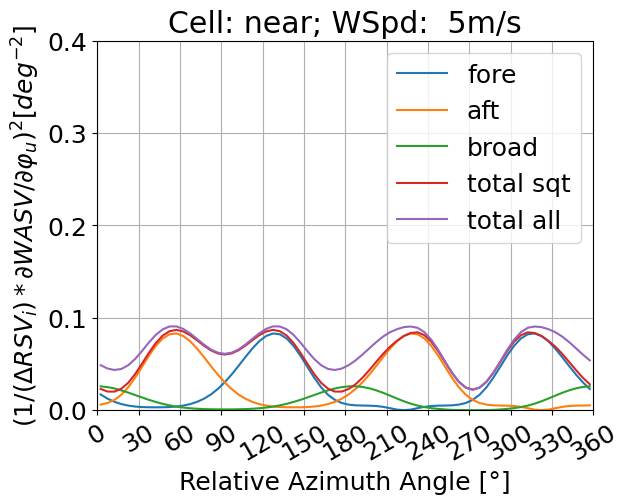

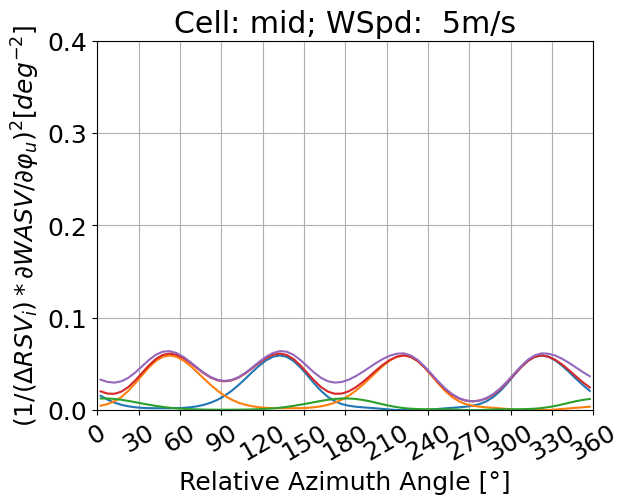

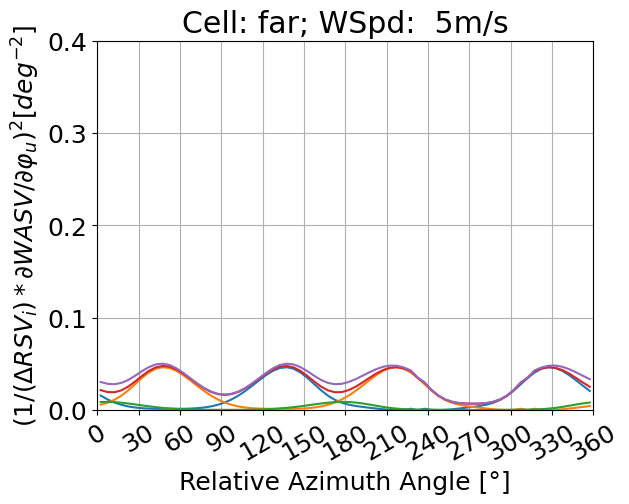

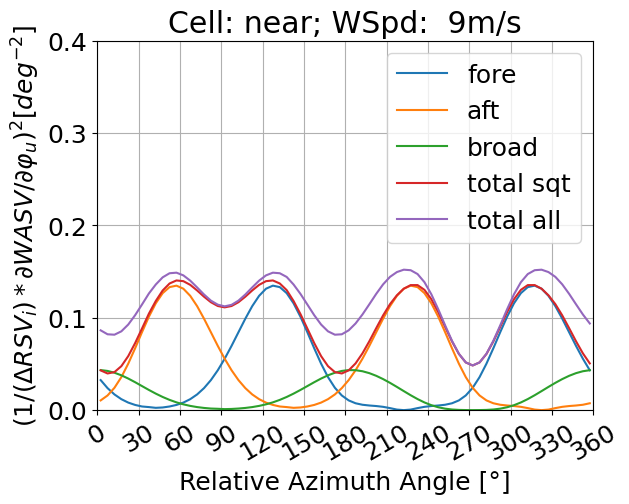

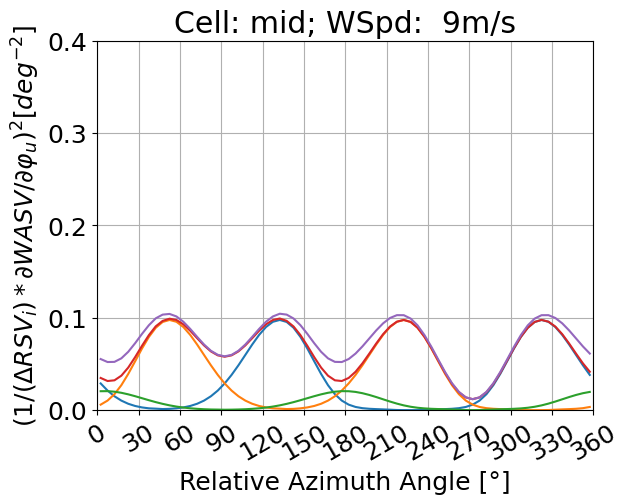

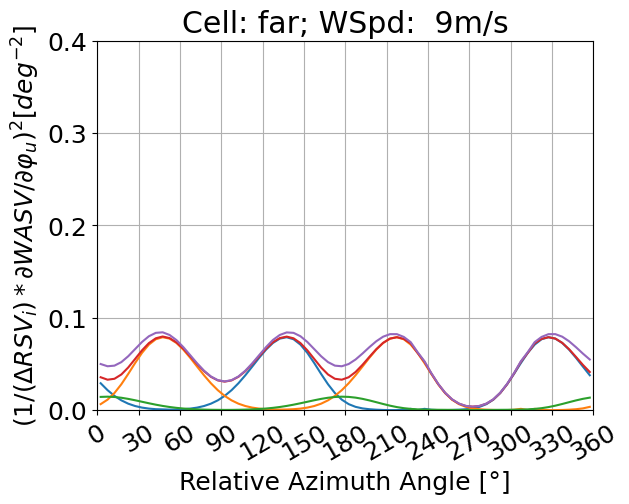

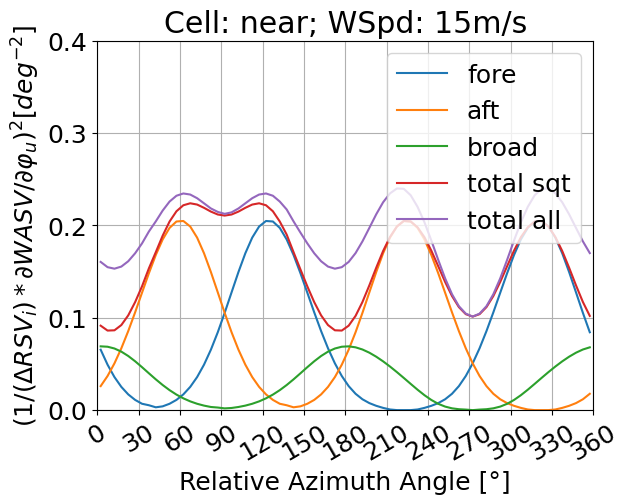

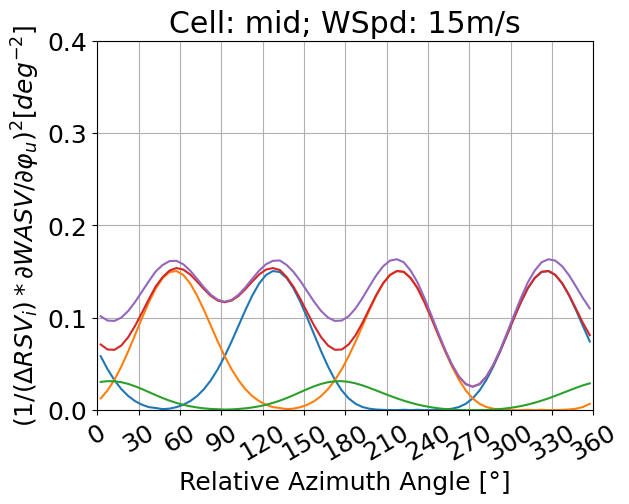

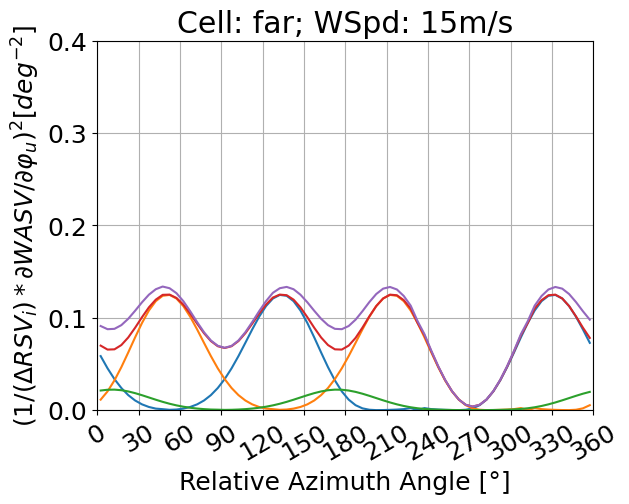

In [76]:
fig_ylim = 0.4

for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_dWASVdazi_2_fore\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_dWASVdazi_2_aft\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_dWASVdazi_2_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='broad',
                )
        ds.norm_dWASVdazi_2_tot_sqt\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_dWASVdazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all',
                )
        #plt.xticks(np.arange(0,361,30))
        #plt.grid()
        #plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        #plt.legend()
        #plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{WASV}/\partial{\varphi_u}\right)^2$')
        plt.xticks(np.arange(-azi_step/2,361,30), np.arange(0,361,30),rotation=30) # shift by azi_step/2 linked to differentiation
        plt.xlim([-azi_step/2,360-azi_step/2]) # shift by azi_step/2 linked to differentiation
        plt.ylim([0,fig_ylim]) ################### TO CHANGE for WPSD > 5 m/s ###########
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        if cell=='near':
            plt.legend()
        plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{WASV}/\partial{\varphi_u}\right)^2 [deg^{-2}]$')
        plt.savefig('../../../SciRec_paper_figures_appendix/' + 
                    f'mouche_seastar_wind_sensi_{cell}_wspd{wspd:02.0f}_ylim{fig_ylim:.2f}.png', bbox_inches='tight')

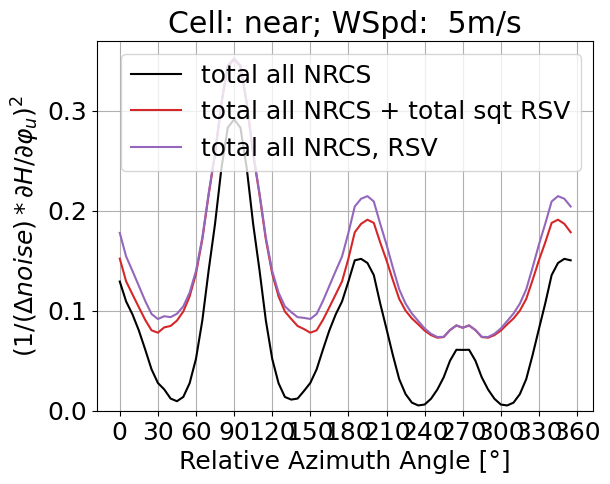

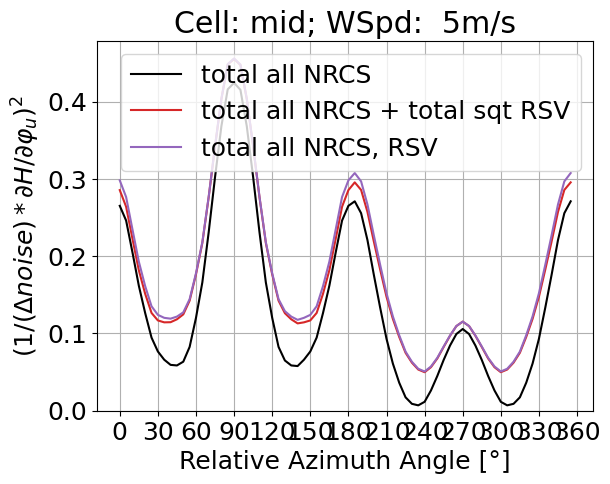

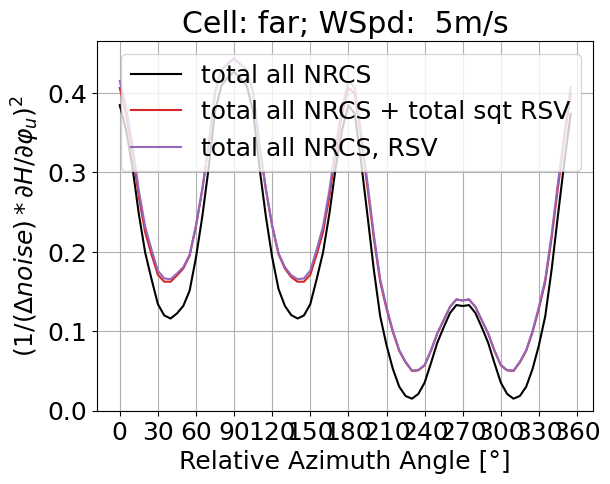

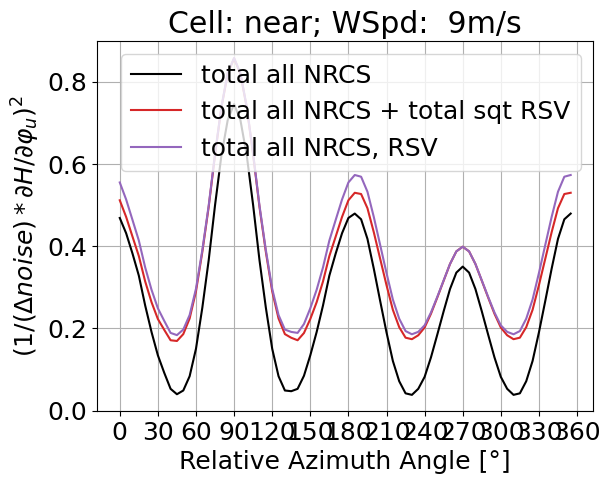

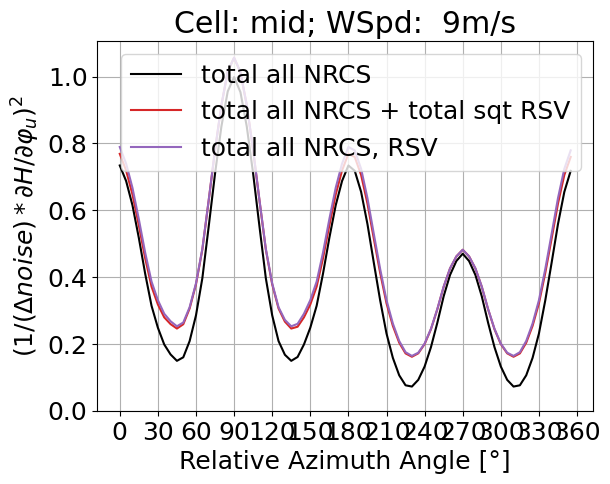

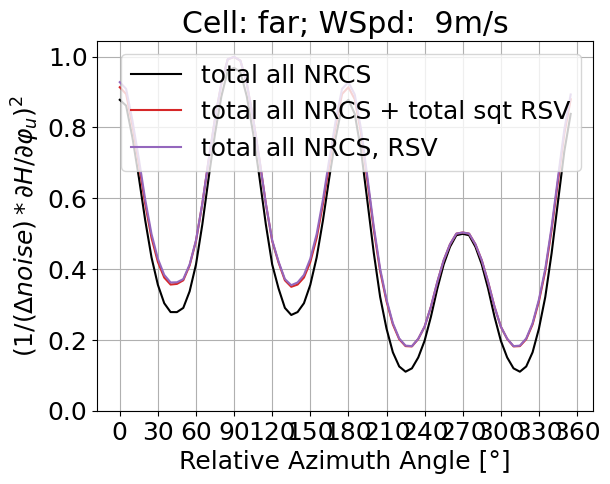

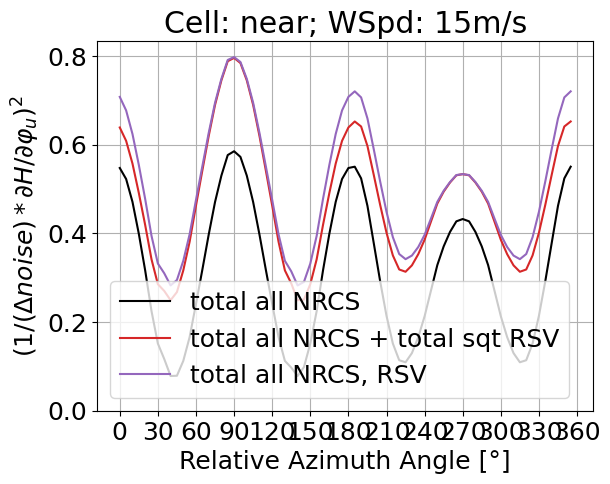

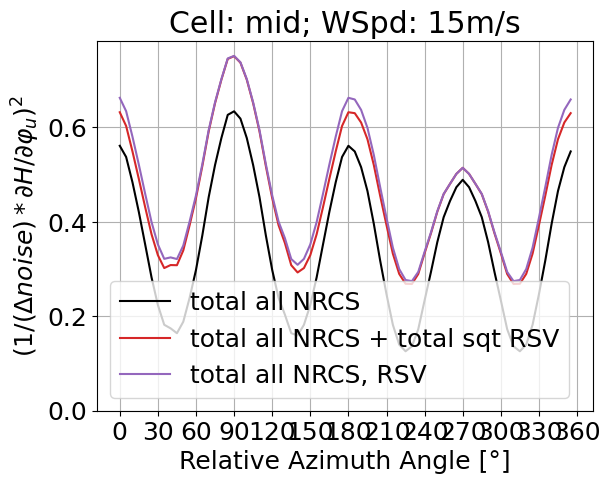

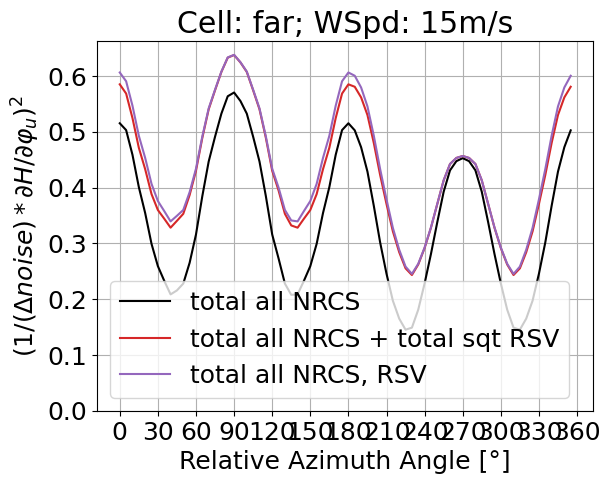

In [54]:
for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_ds0lindazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all NRCS',
                color='k'
                )
        ds.norm_dHdazi_2_tot_sqt_s0_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all NRCS + total sqt RSV',
                color='C3'
                )
        ds.norm_dHdazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all NRCS, RSV',
                color='C4'
                )
        #plt.xticks(np.arange(0,361,30))
        #ax.set_ylim(bottom=0)
        #plt.grid()
        #plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        #plt.legend()
        #plt.ylabel(r'$\left(1/(\Delta noise) * \partial{H}/\partial{\varphi_u}\right)^2$')
        plt.xticks(np.arange(-azi_step/2,361,30), np.arange(0,361,30), rotation=30) # shift by azi_step/2 linked to differentiation
        plt.xlim([-azi_step/2,360-azi_step/2]) # shift by azi_step/2 linked to differentiation
        plt.ylim([0,fig_ylim]) ################### TO CHANGE for WPSD > 5 m/s ###########
        ax.set_ylim(bottom=0)
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        if cell=='near':
            plt.legend()
        plt.ylabel(r'$\left(1/(\Delta noise) * \partial{H}/\partial{\varphi_u}\right)^2 [deg^{-2}]$')
        plt.savefig('../../../SciRec_paper_figures_appendix/' + 
                    f'nscat_mouche_seastar_wind_sensi_{cell}_wspd{wspd:02.0f}_ylim{fig_ylim:.2f}.png', bbox_inches='tight')

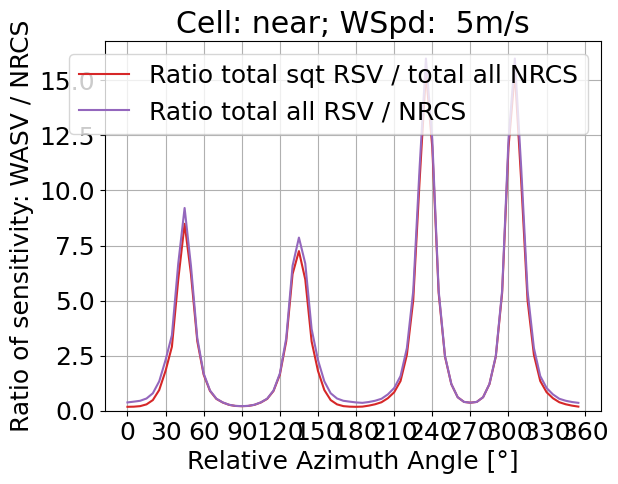

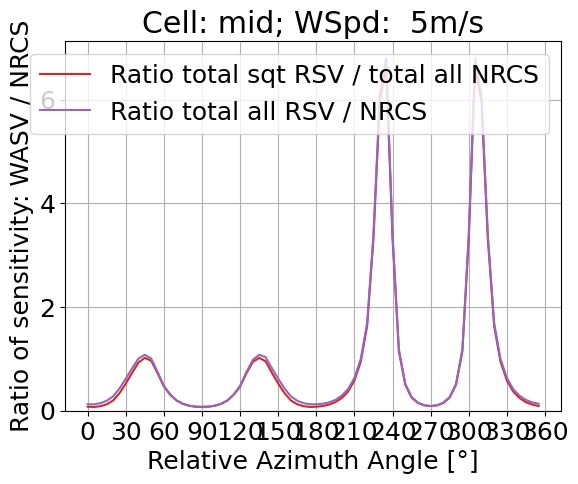

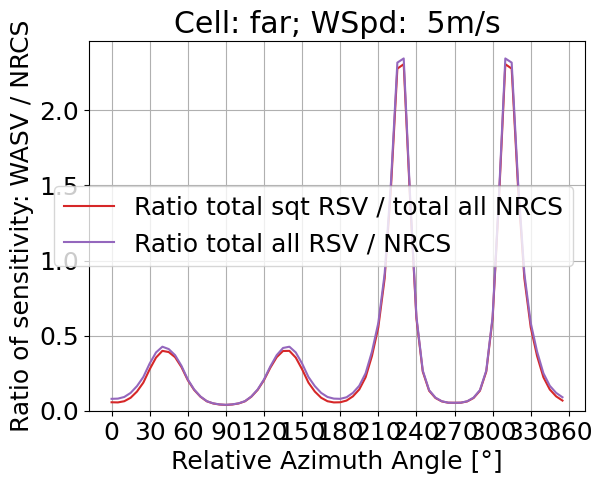

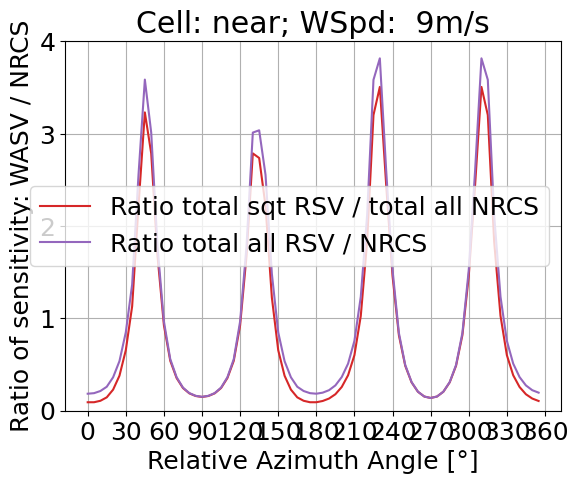

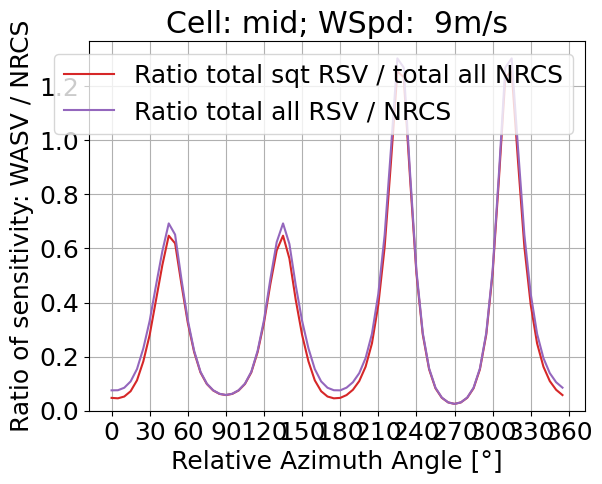

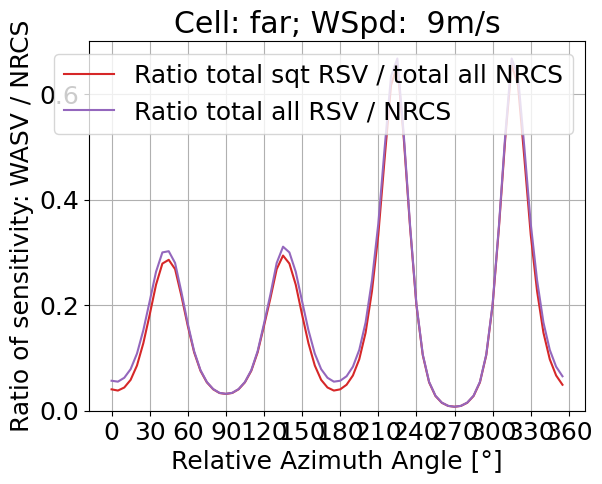

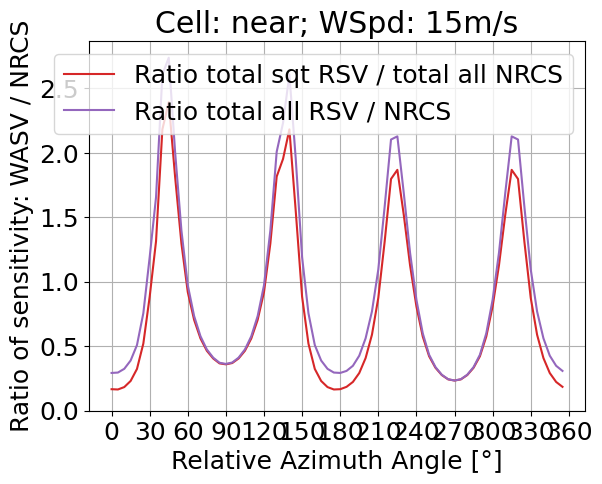

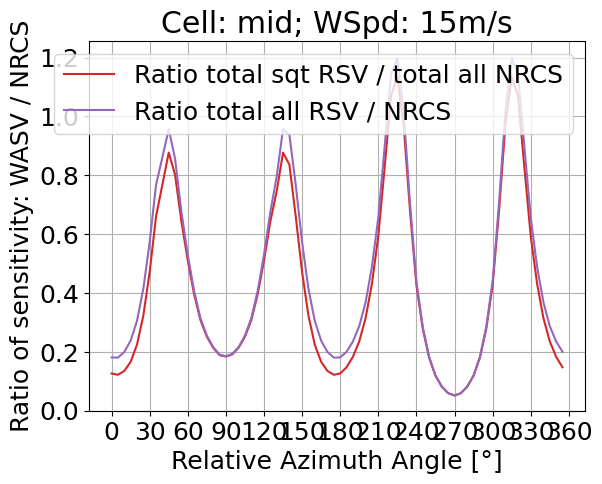

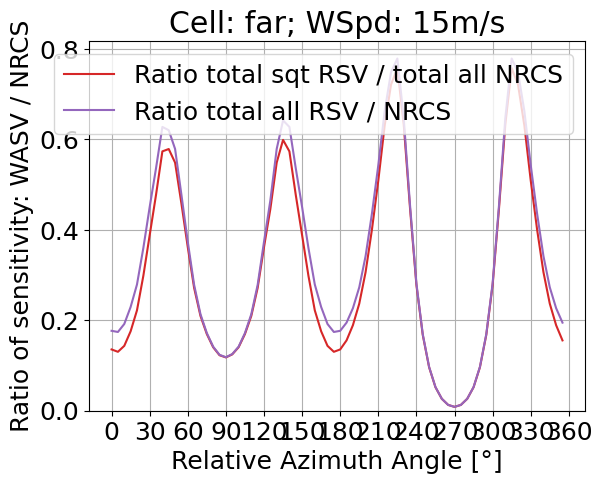

In [55]:
for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_dRdazi_2_tot_sqt_s0_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='Ratio total sqt RSV / total all NRCS',
                color='C3'
                )
        ds.norm_dRdazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='Ratio total all RSV / NRCS',
                color='C4'
                )
        plt.xticks(np.arange(0,361,30))
        ax.set_ylim(bottom=0)
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:2.0f}m/s')
        plt.legend()
        plt.ylabel(r'Ratio of sensitivity: WASV / NRCS')

# Sensitivity to Wind Speed

In [45]:
azi_step =  45
wspd_step = 1

# pol   =  np.array([1])
wspd  =  np.arange(wspd_lim[0], wspd_lim[-1], wspd_step)
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[wspd_mat, theta_broad_mat, azi_mat] =  np.meshgrid(wspd, theta_broad, azi, indexing='ij')
[wspd_mat, theta_sqt_mat, azi_mat] =  np.meshgrid(wspd, theta_sqt, azi, indexing='ij')

dop_broad_VV = seastar.gmfs.doppler.mouche12(
    wspd_mat,
    azi_mat,
    theta_broad_mat,
    'VV',
)

dop_sqt_VV = seastar.gmfs.doppler.mouche12(
    wspd_mat,
    azi_mat,
    theta_sqt_mat,
    'VV',
)

[trash, WASV_broad_VV] = seastar.gmfs.doppler.convertDoppler2Velocity(
    5.5, 
    dop_broad_VV, 
    theta_broad_mat
)
[trash, WASV_sqt_VV] = seastar.gmfs.doppler.convertDoppler2Velocity(
    5.5, 
    dop_sqt_VV, 
    theta_sqt_mat
)

In [46]:
ds2 = xr.Dataset(
    data_vars=dict(
        dop=(['wspd','cell','azi','antenna'], np.stack([dop_broad_VV, dop_sqt_VV], axis=-1))
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        wspd=wspd,
        azi=azi,
        sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds2['WASV'] = (['wspd','cell','azi','antenna'], np.stack([WASV_broad_VV, WASV_sqt_VV], axis=-1))
ds2.WASV.attrs['long_name'] = 'WASV'
ds2.WASV.attrs['units'] = 'm/s'
ds2.wspd.attrs['long_name'] = 'Wind Speed'
ds2.wspd.attrs['units'] = 'm/s'
ds2.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds2.inci_broad.attrs['units'] = '°'
ds2.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds2.inci_sqt.attrs['units'] = '°'
ds2.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds2.azi.attrs['units'] = '°'

In [47]:
ds2

<xarray.Dataset>
Dimensions:          (wspd: 19, cell: 3, azi: 8, antenna: 2)
Coordinates:
  * cell             (cell) <U4 'near' 'mid' 'far'
    inci_broad       (cell) float64 20.0 28.4 33.4
    inci_sqt         (cell) float64 31.5 36.5 40.0
  * antenna          (antenna) <U5 'broad' 'sqt'
  * wspd             (wspd) int32 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19
  * azi              (azi) int32 0 45 90 135 180 225 270 315
    sqt_ground       (cell) float64 52.2 45.0 37.8
    across_distance  (cell) int32 0 90 150
Data variables:
    dop              (wspd, cell, azi, antenna) float32 16.9 14.87 ... 22.78
    WASV             (wspd, cell, azi, antenna) float64 -1.346 ... -0.9655

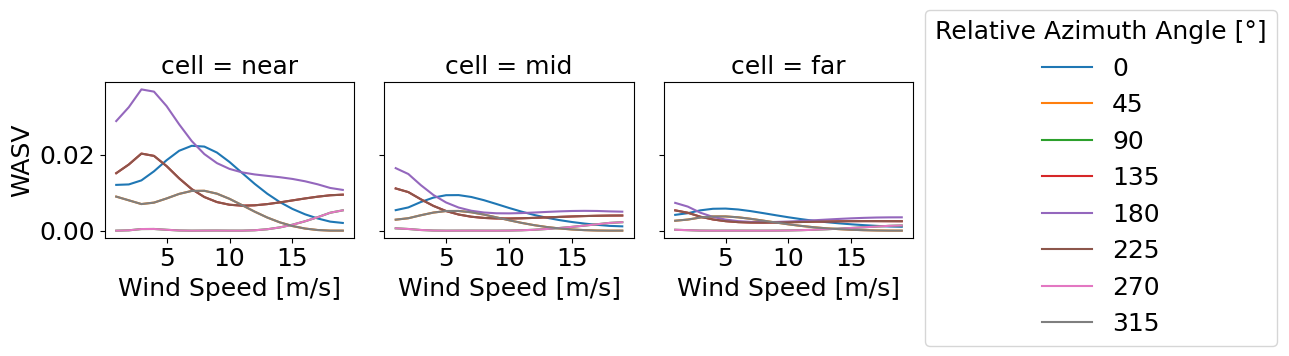

In [48]:
(ds2.WASV.differentiate('wspd')**2).sel(antenna='broad').plot(x='wspd',col='cell',hue='azi')

In [49]:
ds2['dWASV_dwspd_2'] = ds2.WASV.differentiate('wspd')**2
# ds['mean_WASV'] = ds.sigma0_lin.mean(dim='azi')

In [50]:
# ds2['shift_fore'] = np.round((90-ds2.sqt_ground)/azi_step)
# ds2['shift_aft'] = np.round((90+ds2.sqt_ground)/azi_step)
# ds2['shift_fore'] = np.round(45/azi_step)
# ds2['shift_broad'] = np.round(90/azi_step)
# ds2['shift_aft'] = np.round(135/azi_step)
shift_fore  = int(np.round(45/azi_step))
shift_broad = int(np.round(90/azi_step))
shift_aft   = int(np.round(135/azi_step))

ds2['norm_dWASVdwspd_2_fore'] = ds2.dWASV_dwspd_2.roll(azi=shift_fore).sel(antenna='sqt') / noise_RSV_sqt**2
ds2['norm_dWASVdwspd_2_broad'] = ds2.dWASV_dwspd_2.roll(azi=shift_broad).sel(antenna='broad')  / noise_RSV_broad**2
ds2['norm_dWASVdwspd_2_aft'] = ds2.dWASV_dwspd_2.roll(azi=shift_aft).sel(antenna='sqt')  / noise_RSV_sqt**2
ds2['norm_dWASVdwspd_2_tot_sqt'] = ds2['norm_dWASVdwspd_2_fore'] + ds2['norm_dWASVdwspd_2_aft']
ds2['norm_dWASVdwspd_2_tot'] = ds2['norm_dWASVdwspd_2_tot_sqt'] + ds2['norm_dWASVdwspd_2_broad']

C:\Users\adrien-NOV\AppData\Local\Temp\ipykernel_20132\2216303815.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


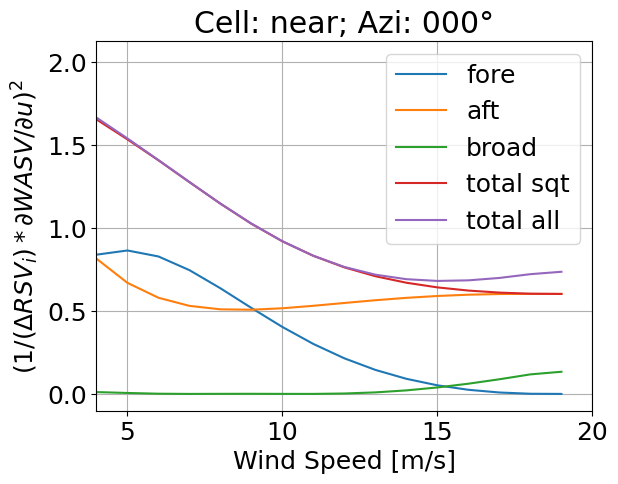

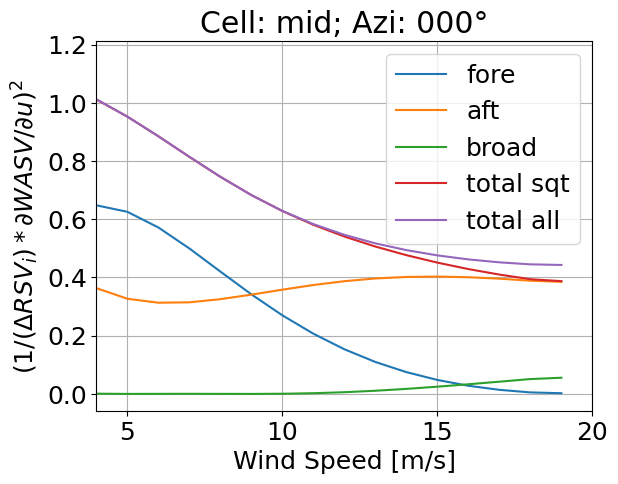

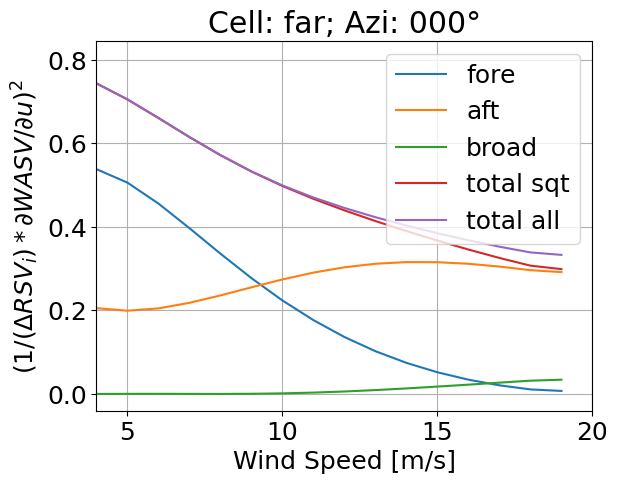

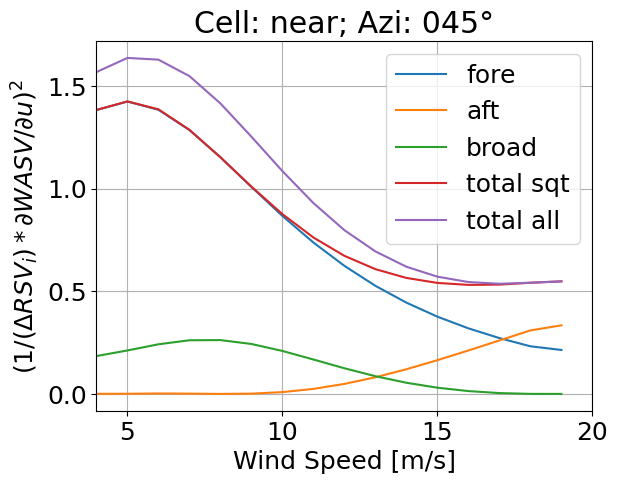

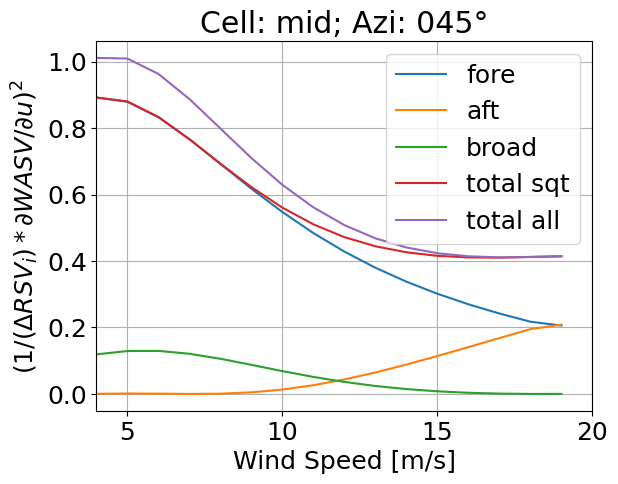

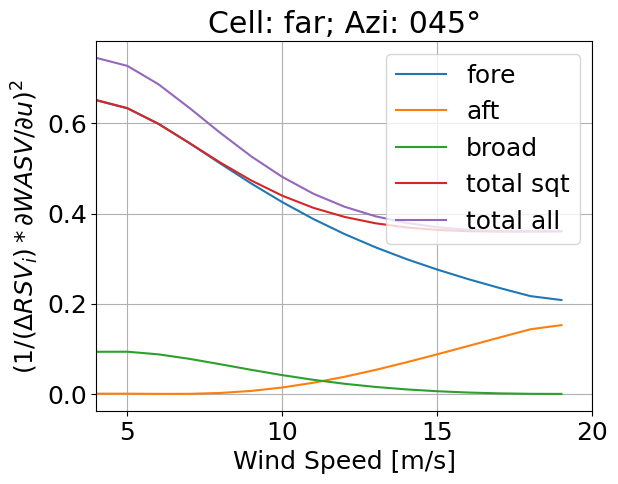

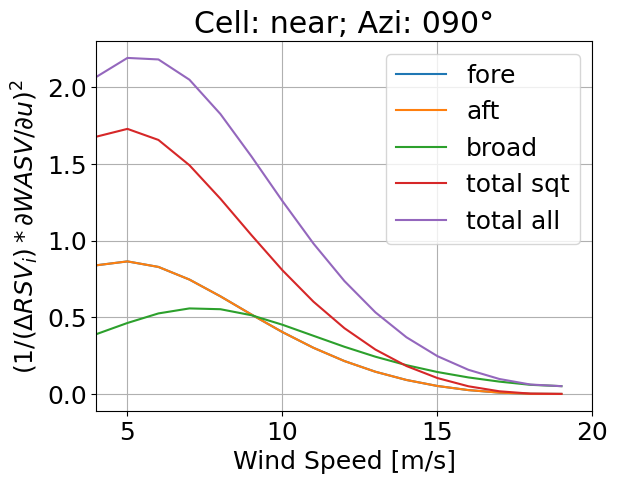

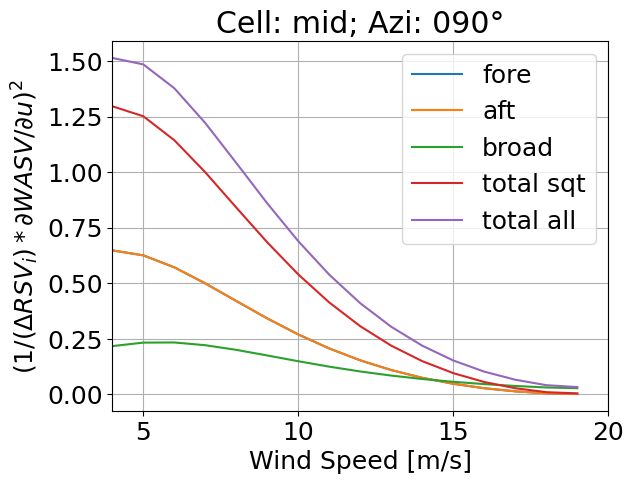

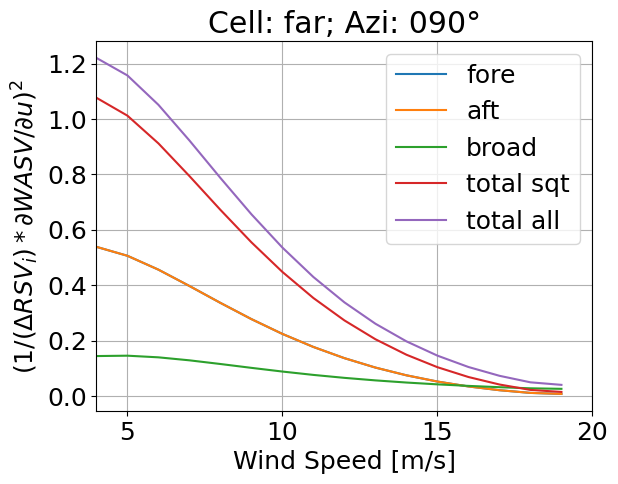

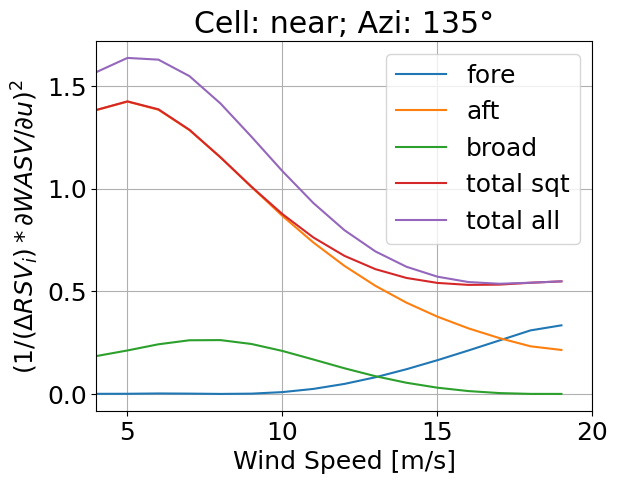

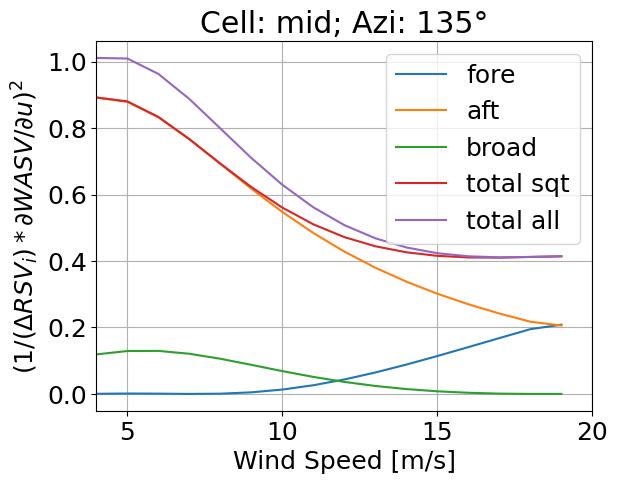

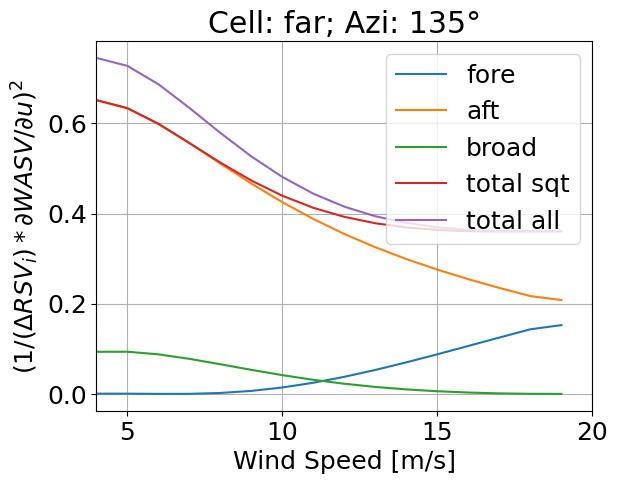

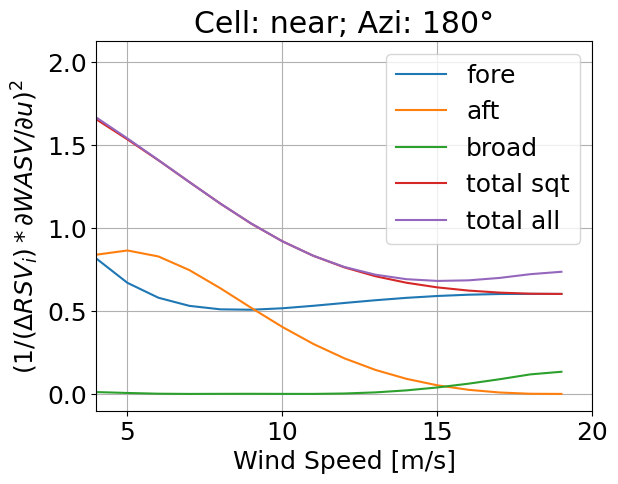

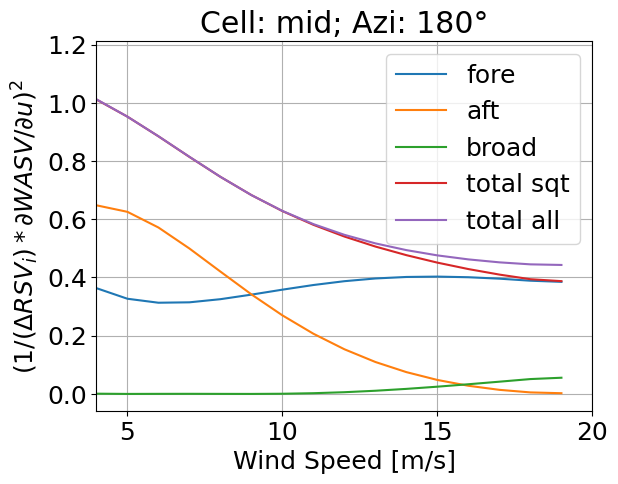

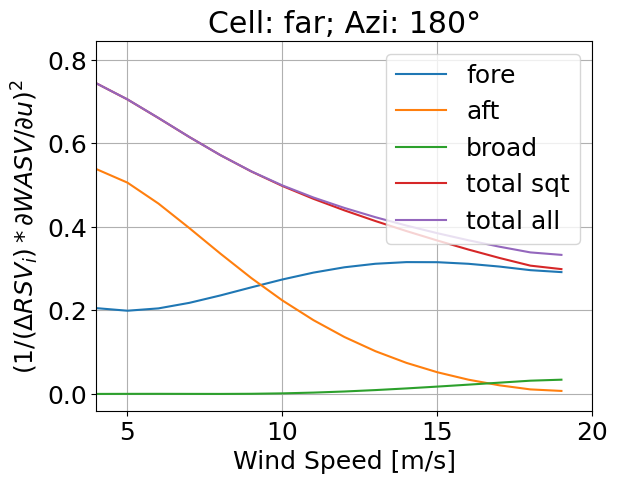

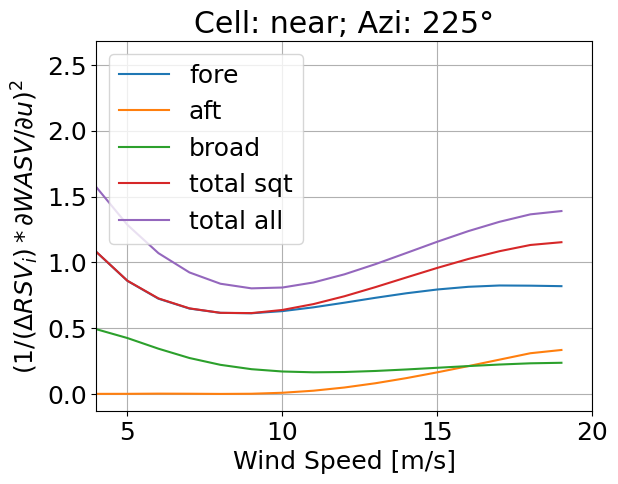

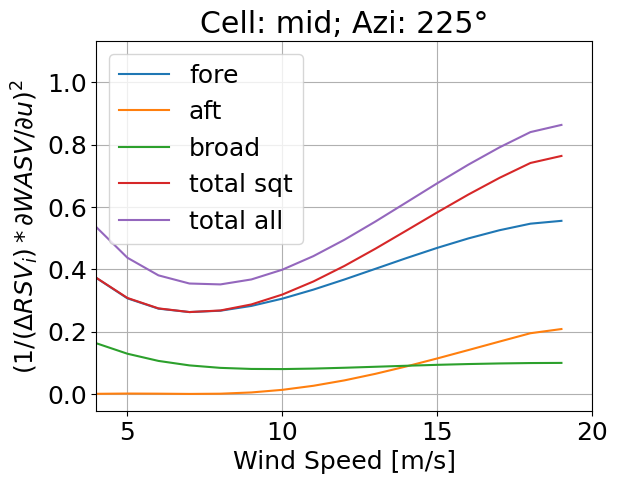

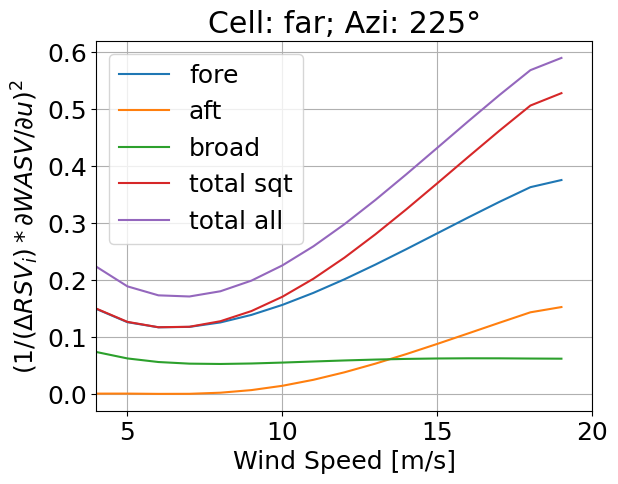

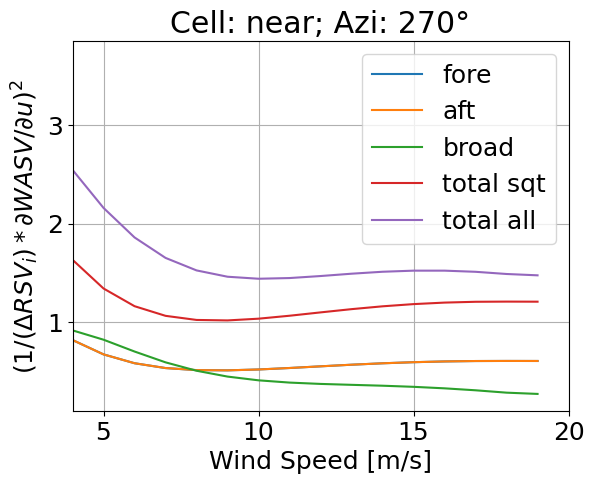

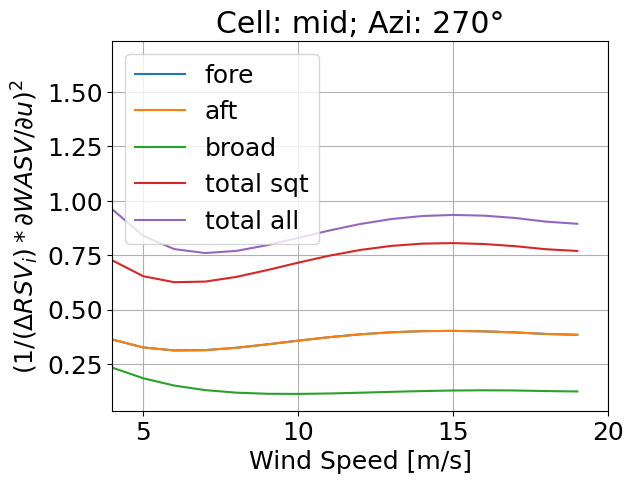

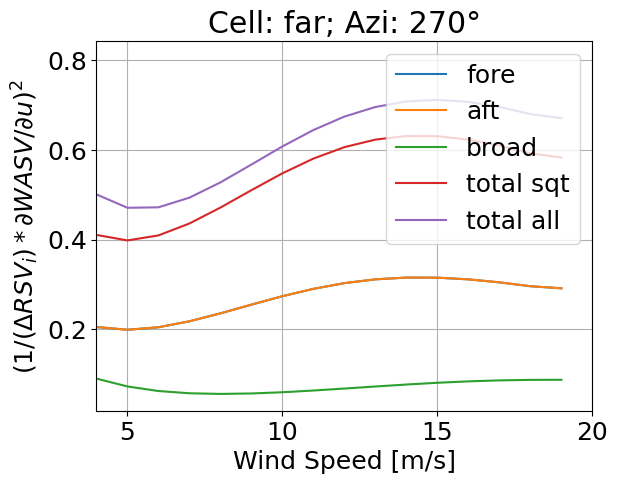

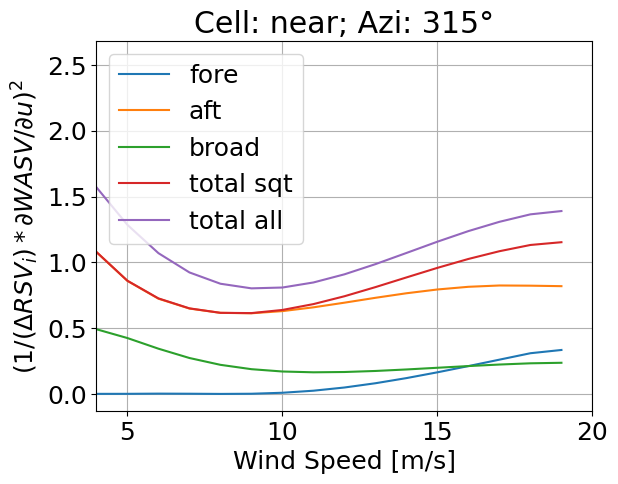

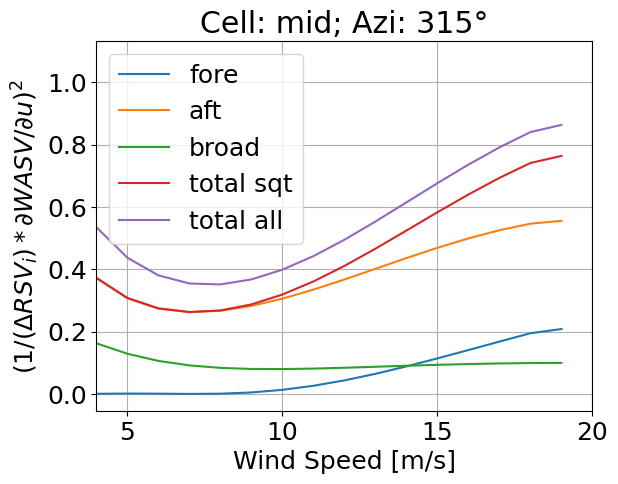

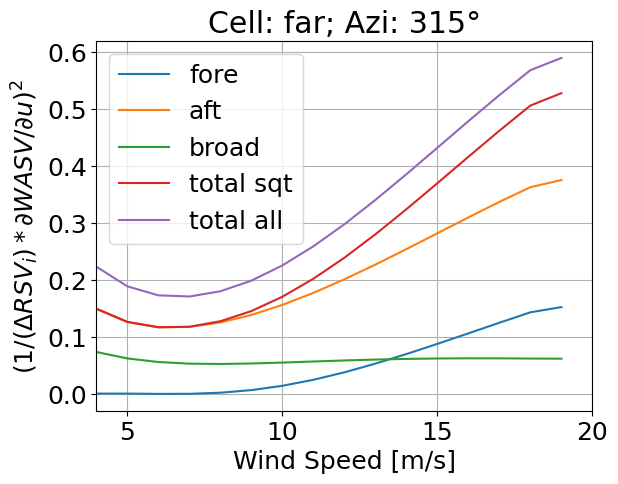

In [51]:
for azi in ds2.azi.values:
    for cell in ds2.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds2.norm_dWASVdwspd_2_fore\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds2.norm_dWASVdwspd_2_aft\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds2.norm_dWASVdwspd_2_broad\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds2.norm_dWASVdwspd_2b_broad\
#             .sel(cell=cell)\
#             .sel(azi=azi)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds2.norm_dWASVdwspd_2_tot_sqt\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds2.norm_dWASVdwspd_2_tot\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total all',
                )
        plt.xlim([4, 20])
#         plt.ylim([0,2000])
#         plt.xticks(np.arange(4,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; Azi: {azi:03.0f}°')
        plt.legend()
        plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{WASV}/\partial{u}\right)^2$')